In [1]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_with_penalization_setup import SpringRodSystemWithPenalizationSetup
from spring_rods_system_solver import SpringRodsSystemSolver
from utils.computational_utils import l2_norm

In [2]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular',
})

In [3]:
model_setup = {
    'interval': (-2, 2),
    'spring_len': 1,
    'step_size': 1/16,
    'material_const': (10, 10),
    'spring_const': (1, 1),
    'body_forces': lambda x: np.where(x < 1, -1, 0),
}

In [4]:
model = SpringRodsSystemSetup(**model_setup)
solver = SpringRodsSystemSolver(model)
real_solution = solver()

In [5]:
def penal_func(x: Tuple[np.ndarray, np.ndarray]):
    spring_len = model_setup['spring_len']
    theta = spring_len - x[0][-1] + x[1][0]
    # This is specific for looking for a solution with assumption of spring compression
    if theta < spring_len:
        return 0
    return (spring_len - theta)**2

# def penal_func(x: Tuple[np.ndarray, np.ndarray]):
#     return (x[0][-1] - x[1][0])**2

In [6]:
penalized_model = SpringRodSystemWithPenalizationSetup(
    **model_setup,
    penalization_function=penal_func,
    penalization_const=1 # this is going to be overwritten
)
solver = SpringRodsSystemSolver(penalized_model)

In [7]:
penal_params = np.array([1 << x for x in range(16)])
# penal_params = np.array([1 / (1 << x) for x in range(10, 20)])

In [8]:
print(penal_params)

[    1     2     4     8    16    32    64   128   256   512  1024  2048
  4096  8192 16384 32768]


In [9]:
cmap = plt.get_cmap('viridis', penal_params.size)

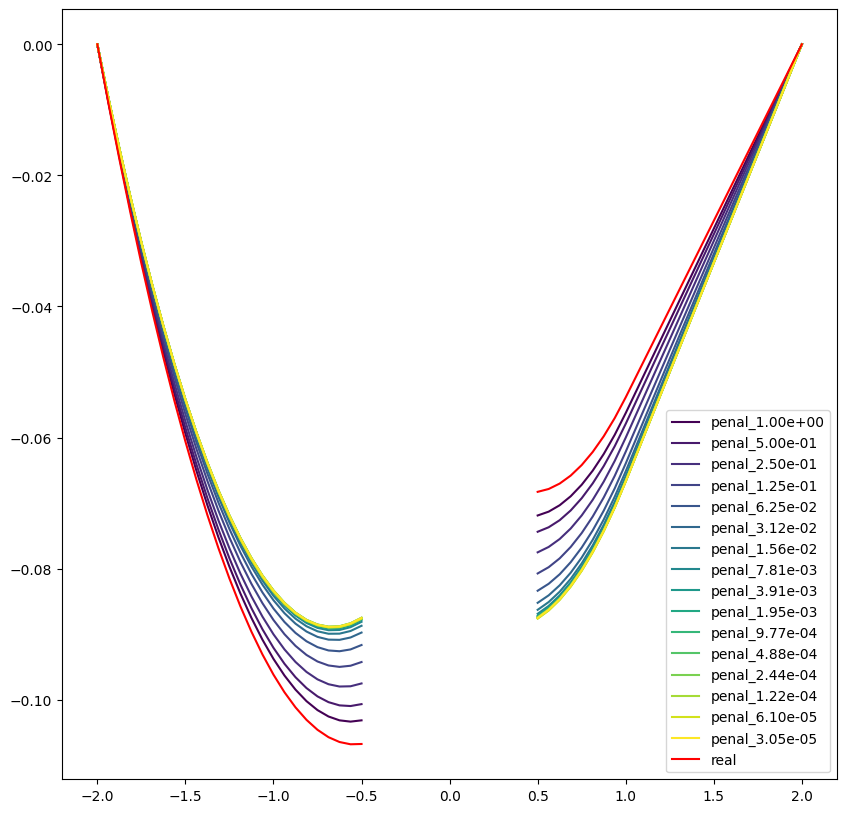

In [12]:
fig = plt.gcf()
fig.set_size_inches(10, 10)

error_norm = []

for idx, val in enumerate(penal_params):
    penalized_model.penalization_const = 1 / val
    solution = solver()

    err = tuple(solution[side] - real_solution[side] for side in (0, 1))
    error_norm.append(l2_norm(values=err, domain=model.domain))

    plt.plot(penalized_model.domain[0], solution[0], color=cmap(idx), label=f'penal_{1 / val:.2e}')
    plt.plot(penalized_model.domain[1], solution[1], color=cmap(idx))

plt.plot(model.domain[0], real_solution[0], color='red', label='real')
plt.plot(model.domain[1], real_solution[1], color='red')

plt.legend()
plt.grid()

([<matplotlib.axis.YTick at 0x7f1c730351c0>,
 [Text(0, 3.756674604556815e-05, '3.76e-05'),
  Text(0, 6.341511550385922e-05, '6.34e-05'),
  Text(0, 9.614931147448076e-05, '9.61e-05'),
  Text(0, 0.00012994874537694607, '1.30e-04'),
  Text(0, 0.00015720905461734123, '1.57e-04'),
  Text(0, 0.00017670251637719308, '1.77e-04'),
  Text(0, 0.0001876391648409667, '1.88e-04'),
  Text(0, 0.00019395407600386117, '1.94e-04'),
  Text(0, 0.0001969913259156542, '1.97e-04'),
  Text(0, 0.00019851769676186923, '1.99e-04'),
  Text(0, 0.0001994805138979407, '1.99e-04'),
  Text(0, 0.00019991739030878877, '2.00e-04'),
  Text(0, 0.00020011614114843693, '2.00e-04'),
  Text(0, 0.00020028012861629903, '2.00e-04'),
  Text(0, 0.00020035091050393857, '2.00e-04'),
  Text(0, 0.000200294254756609, '2.00e-04')])

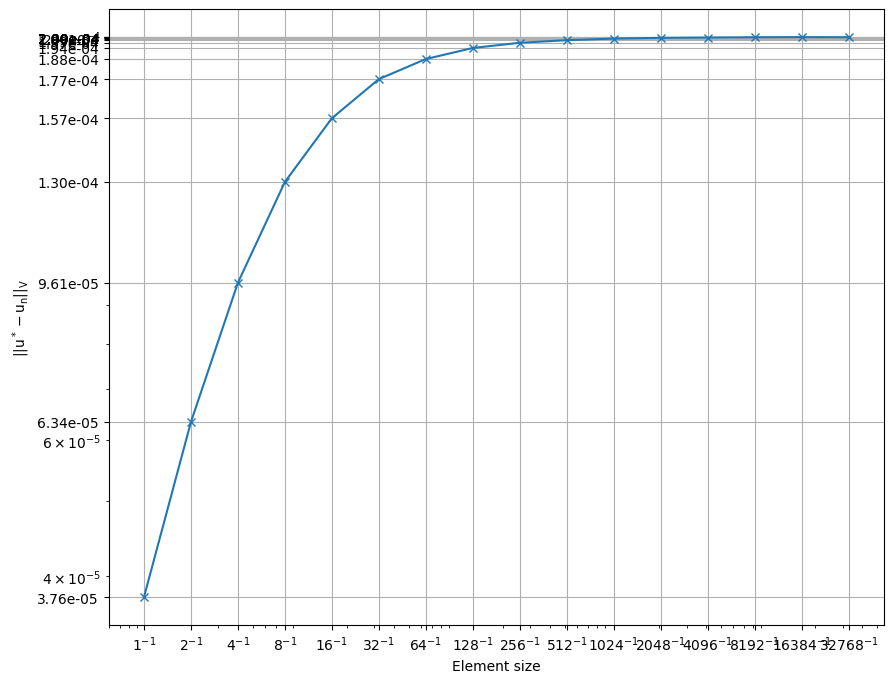

In [14]:
fig = plt.gcf()
fig.set_size_inches(10, 8)

plt.plot(penal_params, error_norm, marker='x')
plt.xlabel('Element size')
plt.ylabel('$||u^* - u_n||_V$')
plt.xscale('log')
plt.yscale('log')

plt.xticks(penal_params, [f'${{{q}}}^{{-1}}$' for q in penal_params])

plt.yticks(error_norm, [f'{err:.2e}' for err in error_norm])